## Characterization of time

Characterization of the time it takes for various steps in the smartSTED pipeline, from WF image acquisition to image scanning a timelapse

In [1]:
import h5py
import os
import glob
import numpy as np
import tifffile
import matplotlib.pyplot as plt

In [2]:
def time_s_fromstr(logline):
    time_s = float(logline.split(' ')[1].split('\n')[0].split('s')[0]) + float(logline.split(' ')[1].split('\n')[0].split('s')[1].split('u')[0])/1e6
    return time_s

['example_data\\area001', 'example_data\\area002', 'example_data\\area003']

3
3
4
6.1003999999994285
0.30020366420250333
0.0
0.0
11.959499999999768
2.8397481314376827
38.059899999999196
3.139951795640186


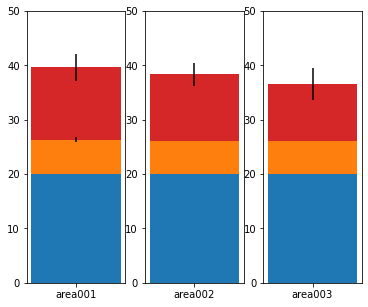

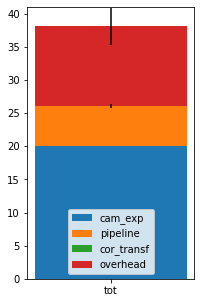

In [12]:
folder_top = 'example_data'

camera_exposure = 20  # ms
update_period = 50  # ms

save = False
    
dirs_top = []
for item in os.listdir(folder_top):
    dirs_top.append(os.path.join(folder_top, item))
print(dirs_top)
print('')

pipelinetimes_all = []
coordtransftimes_all = []
avgframetimes_all = []
overheadtimes_all = []

fig1, axs1 = plt.subplots(1,len(dirs_top), figsize=(2*len(dirs_top),5))
    
for idx, folder in enumerate(dirs_top):
    areaname = folder.split('\\')[-1]
    #print(areaname)
    pipelinetimes = []
    coordtransftimes = []
    avgframetimes = []
    overheadtimes = []
    dirs = [x[0] for x in os.walk(folder)][1:]
    for recdir in dirs:
        for file in os.listdir(recdir):
            if file.endswith('log.txt'):
                logfilepath = os.path.join(recdir, file)

        pipelinetime_temp = [0,0]
        coordtransftime_temp = [0,0]
        pausetime_temp = [0,0]
        scanstarts_temp = []
        scanends_temp = []

        f0 = open(logfilepath, 'r')
        lines = f0.readlines()
        for line in lines:
            param = line.split(' ')[0]
            if param == 'pipeline_start:':
                pipelinetime_temp[0] = time_s_fromstr(line)
            elif param == 'pipeline_end:':
                pipelinetime_temp[1] = time_s_fromstr(line)
            elif param == 'coord_transf_start':
                coordtransftime_temp[0] = time_s_fromstr(line)
            elif param == 'scan_initiate':
                coordtransftime_temp[1] = time_s_fromstr(line)
            elif 'scan_start' in param:
                scanstarts_temp.append(time_s_fromstr(line))
            elif 'scan_end' in param:
                scanends_temp.append(time_s_fromstr(line))
            elif param == 'prepause:':
                pausetime_temp[0] = time_s_fromstr(line)
            elif param == 'postpause:':
                pausetime_temp[1] = time_s_fromstr(line)
        pipelinetimes.append((pipelinetime_temp[1]-pipelinetime_temp[0])*1000)  # in ms
        coordtransftimes.append((coordtransftime_temp[1] - coordtransftime_temp[0])*1000)
        overheadtimes.append((pausetime_temp[1]-pausetime_temp[0])*1000)
        frametimes = np.array(scanends_temp) - np.array(scanstarts_temp)
        frametimes[frametimes<0] = frametimes[frametimes < 0] + 60
        avgframetimes.append(np.mean(frametimes)*1000)
    axs1[idx].bar(areaname, camera_exposure)
    axs1[idx].bar(areaname, np.mean(pipelinetimes), yerr=np.std(pipelinetimes), bottom=camera_exposure)
    axs1[idx].bar(areaname, np.mean(coordtransftimes), yerr=np.std(coordtransftimes), bottom=camera_exposure+np.mean(pipelinetimes))
    axs1[idx].bar(areaname, np.mean(overheadtimes), yerr=np.std(overheadtimes), bottom=camera_exposure+np.mean(pipelinetimes)+np.mean(coordtransftimes))
    axs1[idx].set_ylim(0,50)
    
    pipelinetimes_all.append(pipelinetimes)
    coordtransftimes_all.append(coordtransftimes)
    overheadtimes_all.append(overheadtimes)
    avgframetimes_all.append(avgframetimes)
    
    print(len(pipelinetimes))
    
fig2 = plt.figure(figsize=(3,5))

# for mean of concatenated
pipelinetimes_means = [item for sublist in pipelinetimes_all for item in sublist]
coordtransftimes_means = [item for sublist in coordtransftimes_all for item in sublist]
overheadtimes_means = [item for sublist in overheadtimes_all for item in sublist]
avgframetimes_means = [item for sublist in avgframetimes_all for item in sublist]

plt.bar('tot', camera_exposure)
plt.bar('tot', np.mean(pipelinetimes_means), yerr=np.std(pipelinetimes_means), bottom=camera_exposure)
print(np.mean(pipelinetimes_means)), print(np.std(pipelinetimes_means))
plt.bar('tot', np.mean(coordtransftimes_means), yerr=np.std(coordtransftimes_means), bottom=camera_exposure+np.mean(pipelinetimes_means))
print(np.mean(coordtransftimes_means)), print(np.std(coordtransftimes_means))
plt.bar('tot', np.mean(overheadtimes_means), yerr=np.std(overheadtimes_means), bottom=camera_exposure+np.mean(pipelinetimes_means)+np.mean(coordtransftimes_means))
print(np.mean(overheadtimes_means)), print(np.std(overheadtimes_means))
plt.ylim(0,41)
print(camera_exposure+np.mean(pipelinetimes_means)+np.mean(coordtransftimes_means)+np.mean(overheadtimes_means))
print(np.std(pipelinetimes_means)+np.std(coordtransftimes_means)+np.std(overheadtimes_means))
    
labels = ['cam_exp','pipeline','cor_transf','overhead']
plt.legend(labels, loc='lower center')

if save:
    savefolder = 'example_data'
    plt.savefig(os.path.join(savefolder, 'characterization_speed.svg'))

In [13]:
[np.mean(area) for area in pipelinetimes_all]

[6.332666666666616, 6.000666666665803, 6.000999999999257]